In [44]:
import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyradiance as pr

### Make a scene

In [42]:
my_scene = pr.Scene(
    "my_scene",
    surfaces=["Objects/room.rad"],
    materials=["Objects/materials.mat"])

my_view = pr.View(
    vtype='a',
    position=(6, 6, 4),
    direction=(0, -1, 0),
    horiz=180,
    vert=180,
)
my_scene.add_view(my_view)

dt = datetime.datetime.now()
for prim in pr.parse_primitive(pr.gendaylit(dt, 37, 122, 120, dirnorm=800, diffhor=80).decode()):
    my_scene.add_source(prim)
my_scene.add_source(pr.Primitive("skyfunc", "glow", "skyglow", [], [1, 1, 1, 0]))
my_scene.add_source(pr.Primitive("skyglow", "source", "skydome", [], [0, 0, 1, 180]))
my_scene.add_source(pr.Primitive("skyglow", "source", "groundplane", [], [0, 0, -1, 180]))

### Render

In [3]:
img = pr.render(my_scene, resolution=(800, 800), ambbounce=1, nproc=8, quality="L")

### Tone-mapping

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00053596497..1.1601562].


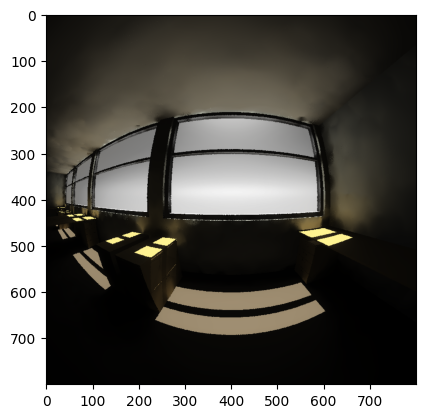

In [4]:
with open("raw.hdr", "wb") as f:
    f.write(img)
img_tm = pr.pcond("raw.hdr", human=True)
_, yres, _, xres = pr.getinfo(img, dimension_only=True).decode().split()
xres, yres = int(xres), int(yres)
img_data = pr.pvalue(img_tm, header=False, outform='f', resstr=False)
img_array = np.frombuffer(img_data, dtype=np.single).reshape(xres, yres, 3)
plt.imshow(img_array)

### Luminance falsecoloring

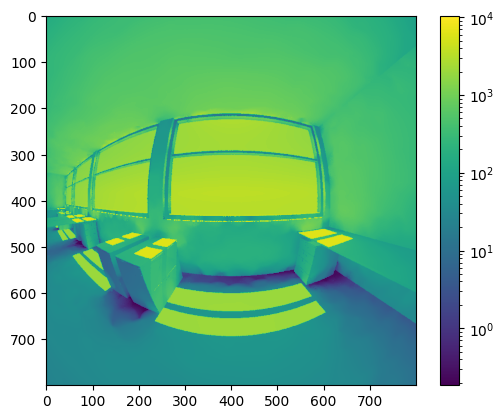

In [5]:
img_data = pr.pvalue(img, header=False, outform='f', resstr=False)
img_array = np.frombuffer(img_data, dtype=np.single).reshape(xres, yres, 3)
luminance = img_array[:, :, 0] * 47.4 + img_array[:, :, 1] * 119.9 + img_array[:, :, 2] * 11.6
plt.imshow(luminance, cmap='viridis', norm=mpl.colors.LogNorm())
plt.colorbar()

### Set sampling parameters

In [24]:
sp = pr.SamplingParameters()
sp.aa = 0
sp.ad = 32
sp.ab = 2

### Rendering with rtpict

In [17]:
img = pr.rtpict(my_view, my_scene.octree, xres=3200, yres=3200, nproc=8, params=sp.args())

### Tone-mapping

In [21]:
with open("raw2.hdr", "wb") as f:
    f.write(pr.pfilt(img, one_pass=True, xres="/4", yres="/4", gaussian_filter_radius=0.6))
img_arr = np.frombuffer(pr.pvalue(pr.pcond("raw2.hdr", human=True), header=False, outform='f', resstr=False), dtype=np.single).reshape(800, 800, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.696846e-05..1.1601562].


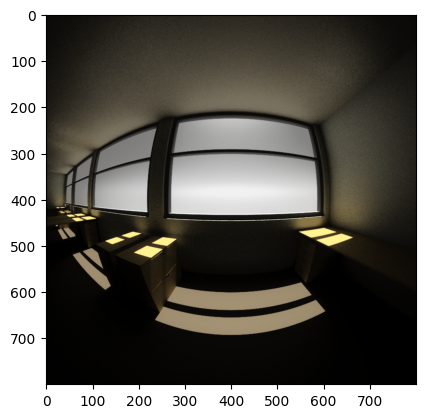

In [22]:
plt.imshow(img_arr)

### BSDF analysis

In [25]:
ttree = pr.BSDF("./ms6858_g6.xml")

In [27]:
ttree.info
ttree.components

'Peak front hemispherical reflectance: 0.6697068687106507\nPeak back hemispherical reflectance: 0.4586453171369893\nPeak front hemispherical transmittance: 0.1542515436620161\nPeak back hemispherical transmittance: 0.158302730760577\nDiffuse front reflectance: (0.3373476685244758, 0.3373476685244758, 0.3373476383632448)\nDiffuse back reflectance: (0.1579190691173867, 0.1579190691173867, 0.1579190549983221)\nDiffuse front transmittance: (0.02377023318848092, 0.02377023318848092, 0.023770231063256524)\nDiffuse back transmittance: (0.056808163590893315, 0.056808163590893315, 0.05680815851184785)'

In [28]:
klems = pr.BSDF("./ms6858_kf.xml")
klems.info
klems.components

'Peak front hemispherical reflectance: 0.6277036639064524\nPeak back hemispherical reflectance: 0.4657787077470401\nPeak front hemispherical transmittance: 0.15300139238615668\nPeak back hemispherical transmittance: 0.15632780921548323\nDiffuse front reflectance: (0.34429912754350356, 0.34429912754350356, 0.3442990967607637)\nDiffuse back reflectance: (0.25035165201405146, 0.25035165201405146, 0.2503516296308702)\nDiffuse front transmittance: (0.06922969567184906, 0.06922969567184906, 0.06922968948223211)\nDiffuse back transmittance: (0.06734810214164028, 0.06734810214164028, 0.0673480961202509)'

In [40]:
ttree_tau_h = []
klems_tau_h = []
for i in range(90):
    ttree_tau_h.append(ttree.direct_hemi(i, 0, 't'))
    klems_tau_h.append(klems.direct_hemi(i, 0, 't'))

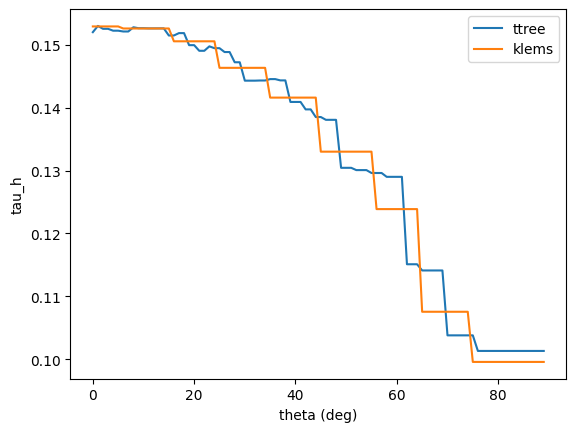

In [41]:
plt.plot(ttree_tau_h, label="ttree")
plt.plot(klems_tau_h, label="klems")
plt.xlabel("theta (deg)")
plt.ylabel("tau_h")
plt.legend()